# Setup

**Download deepdrive_course repository when running in Google Colab (to have access to libraries)**

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  !git clone https://github.com/abojda/deepdrive_course.git dd_course
  !pip install dd_course/

Cloning into 'dd_course'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25 (delta 5), reused 24 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), 3.82 KiB | 782.00 KiB/s, done.
Processing ./dd_course
  Preparing metadata (setup.py) ... done
  Created wheel for deepdrive-course: filename=deepdrive_course-1.0.0-py3-none-any.whl size=3969 sha256=53bbe53995648d855e31a11035e433de7215730825e963f52eab942347820fbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-9xyd5t01/wheels/c3/5a/84/c1256f884da07da8ab8df39dbe257d0084f1b389ad756bdb92
Successfully built deepdrive-course


In [2]:
!pip install einops torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

## Load dataset

In [4]:
from torchvision.transforms import ToTensor
from deepdrive_course.quickdraw.datasets import QuickdrawDatasetInMemory
from deepdrive_course.utils import stratified_train_test_split

class_names=['banana', 'baseball bat', 'carrot', 'clarinet', 'crayon',
             'pencil','boomerang', 'hockey stick', 'fork', 'knife']

transform = ToTensor()

full_ds = QuickdrawDatasetInMemory(root='data', classes=class_names, transform=transform)
train_ds, test_ds, train_indices, test_indices = stratified_train_test_split(full_ds, train_size=0.8)

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy ==> data/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy ==> data/baseball bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/carrot.npy ==> data/carrot.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clarinet.npy ==> data/clarinet.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/crayon.npy ==> data/crayon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pencil.npy ==> data/pencil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/boomerang.npy ==> data/boomerang.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hockey%20stick.npy ==> data/hockey stick.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fork.npy ==> data/fork.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/knife.npy ==> dat

# Basic exploratory data analysis

## Histogram of classes for full, training and test dataset

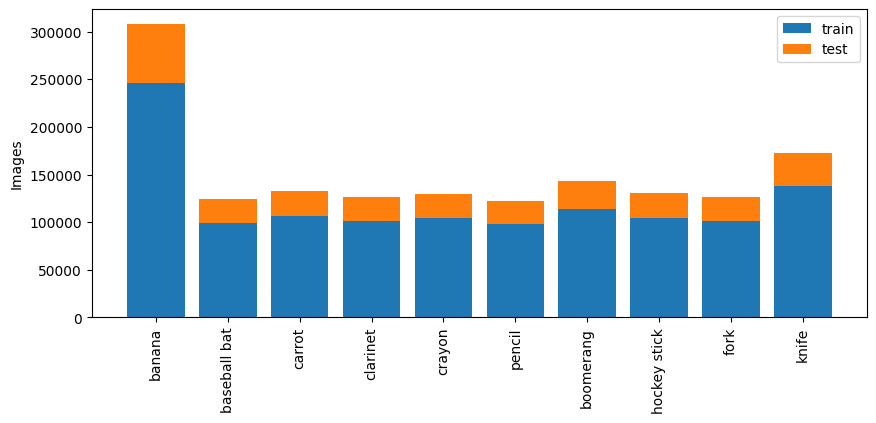

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

train_targets = np.array(full_ds.targets)[train_indices]
test_targets = np.array(full_ds.targets)[test_indices]

train_counts, _ = np.histogram(train_targets, bins=len(class_names))
test_counts, _ = np.histogram(test_targets, bins=len(class_names))

ax.bar(class_names, train_counts, align='center')
ax.bar(class_names, test_counts, bottom=train_counts, align='center')
ax.set_ylabel('Images')
ax.set_xticks(ax.get_xticks(), class_names, rotation='vertical')
ax.legend(['train', 'test'])
plt.show();

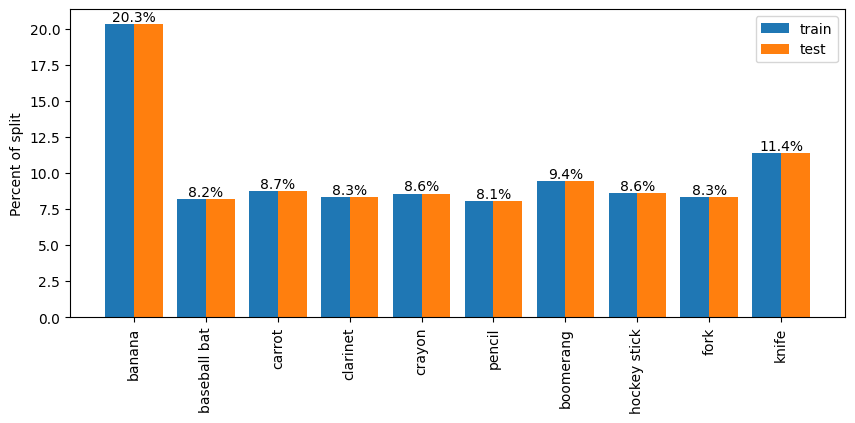

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

train_sum = sum(train_counts)
test_sum = sum(test_counts)

train_percents = [100 * count / train_sum for count in train_counts]
test_percents = [100 * count / test_sum for count in test_counts]

idx = np.arange(10)

bar1 = ax.bar(idx-0.2, train_percents, width=0.4)
bar2 = ax.bar(idx+0.2, test_percents, width=0.4)
ax.set_xticks(idx, class_names, rotation='vertical')
ax.set_ylabel('Percent of split')
ax.legend(['train', 'test'])

for i, rect in enumerate(bar1):
  ax.text(s=f'{train_percents[i]:.1f}%', x=idx[i], y=rect.get_height()+0.2, ha='center')

plt.show();

## Image examples for each class

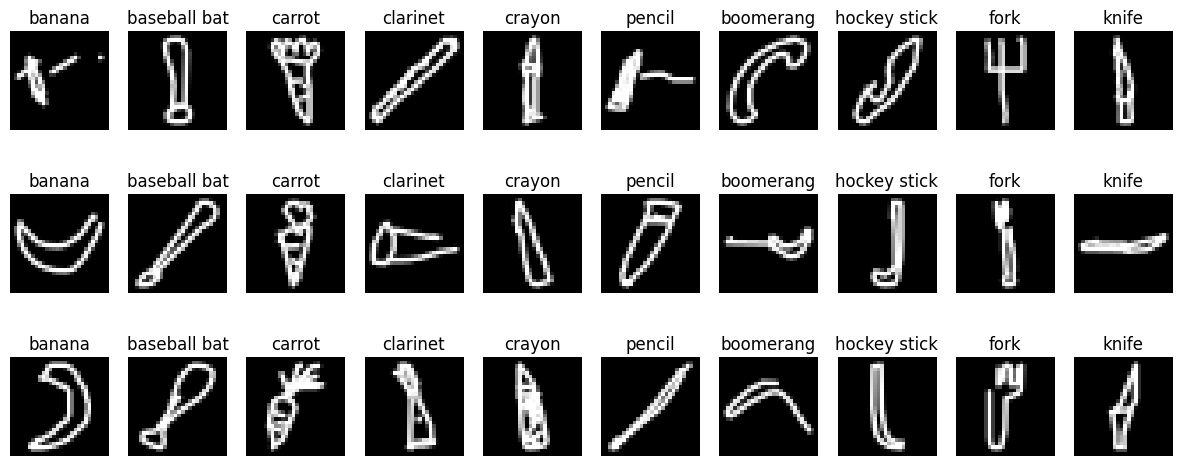

In [7]:
n = 3 # Number of examples for each class
targets_np = np.array(full_ds.targets)

fig, ax = plt.subplots(n,10, figsize=(15,n*2))

for i in range(len(class_names)):
    idxs = np.argwhere(targets_np == i).squeeze()

    for j in range(n):
        idx = np.random.choice(idxs)
        img, target = full_ds[idx]
        img = img.numpy().reshape((28,28))

        ax[j][i].imshow(img, cmap='gray')
        ax[j][i].set_title(class_names[i])
        ax[j][i].set_axis_off()

# Training and validation

## Create dataloaders

In [8]:
from torch.utils.data import DataLoader
torch.manual_seed(42)
np.random.seed(42)

batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      shuffle=True)

test_dl = DataLoader(test_ds,
                     batch_size=batch_size,
                     shuffle=True)

## Device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Model

In [10]:
from deepdrive_course.quickdraw.models import MLP, CNN
from torchsummary import summary

# model = MLP(n_classes=len(class_names), hidden_size=512)
model = CNN(n_classes=len(class_names))

model.to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,640
              ReLU-6           [-1, 32, 22, 22]               0
           Flatten-7                [-1, 15488]               0
            Linear-8                   [-1, 10]         154,890
        LogSoftmax-9                   [-1, 10]               0
Total params: 160,778
Trainable params: 160,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 0.61
Estimated Total Size (MB): 1.19
-------------------------------------------

## Training and validation loops

In [11]:
from tqdm import tqdm

lr=1e-3
epochs=10

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch}")

    # Training loop
    train_loss = 0
    train_acc = 0
    n_batches = len(train_dl)
    n_samples = len(train_dl.dataset)

    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_dl)):

        data, target = data.to(device), target.to(device)

        pred = model(data)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred_class = torch.argmax(pred, dim=1)
        is_correct = pred_class.eq(target)
        train_acc += is_correct.sum().detach().cpu().numpy()
        train_loss += loss.detach().cpu().numpy()

    train_loss /= n_batches
    train_losses.append(train_loss)
    train_acc /= n_samples
    train_accs.append(train_acc)
    print(f"Training loss: {train_loss:.4f}")
    print(f"Training accuracy: {train_acc:.3f}")


    # Validation loop
    test_loss = 0
    test_acc = 0
    n_batches = len(test_dl)
    n_samples = len(test_dl.dataset)

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_dl)):
            data, target = data.to(device), target.to(device)

            pred = model(data)
            loss = loss_fn(pred, target)

            pred_class = torch.argmax(pred, dim=1)
            is_correct = (pred_class == target)
            test_acc += is_correct.sum().detach().cpu().numpy()
            test_loss += loss.detach().cpu().numpy()

    test_loss /= n_batches
    test_losses.append(test_loss)
    test_acc /= n_samples
    test_accs.append(test_acc)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_acc:.3f}")


Epoch 0


100%|██████████| 18924/18924 [03:04<00:00, 102.84it/s]


Training loss: 0.6301
Training accuracy: 0.804


100%|██████████| 4731/4731 [00:36<00:00, 128.64it/s]


Test loss: 0.5449
Test accuracy: 0.829

Epoch 1


100%|██████████| 18924/18924 [02:51<00:00, 110.18it/s]


Training loss: 0.5184
Training accuracy: 0.837


100%|██████████| 4731/4731 [00:35<00:00, 132.43it/s]


Test loss: 0.5224
Test accuracy: 0.835

Epoch 2


100%|██████████| 18924/18924 [02:50<00:00, 110.79it/s]


Training loss: 0.4921
Training accuracy: 0.844


100%|██████████| 4731/4731 [00:36<00:00, 128.26it/s]


Test loss: 0.5083
Test accuracy: 0.840

Epoch 3


100%|██████████| 18924/18924 [02:52<00:00, 109.50it/s]


Training loss: 0.4785
Training accuracy: 0.848


100%|██████████| 4731/4731 [00:39<00:00, 118.75it/s]


Test loss: 0.5098
Test accuracy: 0.841

Epoch 4


100%|██████████| 18924/18924 [02:57<00:00, 106.77it/s]


Training loss: 0.4697
Training accuracy: 0.851


100%|██████████| 4731/4731 [00:36<00:00, 128.12it/s]


Test loss: 0.5057
Test accuracy: 0.842

Epoch 5


100%|██████████| 18924/18924 [02:51<00:00, 110.63it/s]


Training loss: 0.4631
Training accuracy: 0.853


100%|██████████| 4731/4731 [00:36<00:00, 129.75it/s]


Test loss: 0.4998
Test accuracy: 0.844

Epoch 6


100%|██████████| 18924/18924 [02:50<00:00, 110.99it/s]


Training loss: 0.4585
Training accuracy: 0.854


100%|██████████| 4731/4731 [00:37<00:00, 127.07it/s]


Test loss: 0.5023
Test accuracy: 0.842

Epoch 7


100%|██████████| 18924/18924 [02:50<00:00, 110.84it/s]


Training loss: 0.4552
Training accuracy: 0.855


100%|██████████| 4731/4731 [00:37<00:00, 126.60it/s]


Test loss: 0.5055
Test accuracy: 0.842

Epoch 8


100%|██████████| 18924/18924 [02:52<00:00, 109.76it/s]


Training loss: 0.4526
Training accuracy: 0.855


100%|██████████| 4731/4731 [00:36<00:00, 130.17it/s]


Test loss: 0.5028
Test accuracy: 0.843

Epoch 9


100%|██████████| 18924/18924 [02:52<00:00, 109.83it/s]


Training loss: 0.4496
Training accuracy: 0.856


100%|██████████| 4731/4731 [00:36<00:00, 129.18it/s]

Test loss: 0.5017
Test accuracy: 0.843


## Visualization of training curves

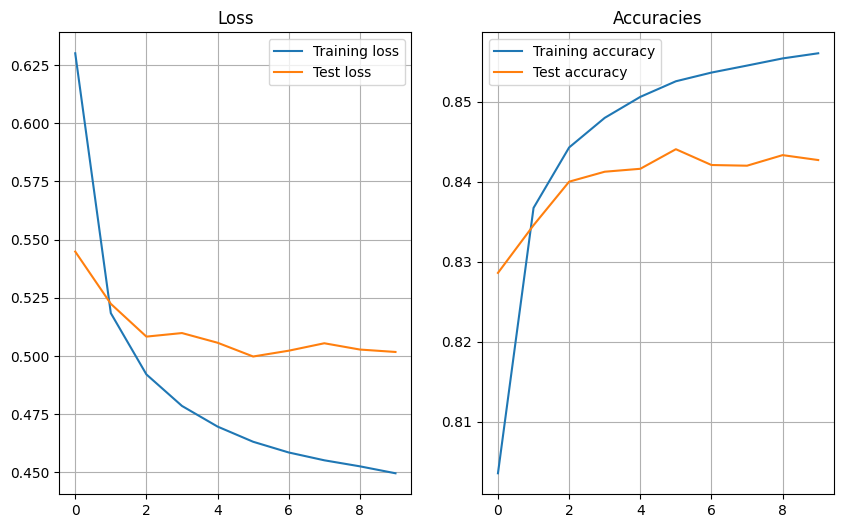

In [12]:
x = np.arange(epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.plot(x, train_losses)
ax1.plot(x, test_losses)
ax1.legend(["Training loss", "Test loss"])
ax1.set_title("Loss")
ax1.grid()

ax2.plot(x, train_accs)
ax2.plot(x, test_accs)
ax2.legend(["Training accuracy", "Test accuracy"])
ax2.set_title("Accuracies")
ax2.grid()

plt.show()